# [IAPR 2019:][iapr2019] Lab 1 ‒  Image segmentation

**Author:** Kristoffer Landsnes & Arthur Alain Bernard Gassner
**Due date:** 04.04.2019

[iapr2019]: https://github.com/LTS5/iapr-2019

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [62]:
import tarfile
import os
import cv2
import numpy as np
import skimage.segmentation as seg
import skimage.color as color
from skimage.measure import label, regionprops
import pprint


data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

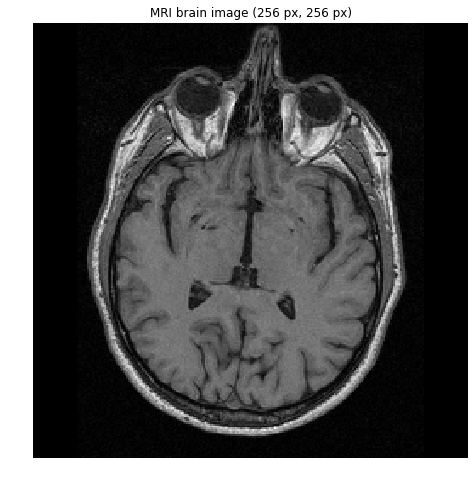

In [63]:
import skimage.io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing


### REGION GROWING USING THRESHOLD

In [64]:
def get_neighbors(px, img):
    """return list of the neighbors of px (x,y) in img"""

    px_x, px_y = px[0], px[1]
    height = len(img)
    width = len(img[0])
    
    # Check that px is within the bounds of the img
    assert px_x < height
    assert px_y < width
    
    neighbors = []
    
    # North-West
    if px_x > 0 and px_y > 0:
        neighbors.append((px_x - 1, px_y - 1))
            
    # North
    if px_x > 0:
        neighbors.append((px_x - 1, px_y))
        
    # North-East
    if px_x > 0 and px_y < width:
        neighbors.append((px_x - 1, px_y + 1))
            
    # West
    if px_y > 0:
        neighbors.append((px_x, px_y - 1))

    # East
    if px_y < width:
        neighbors.append((px_x, px_y + 1))
            
    # South-West
    if px_x < height and px_y > 0:
        neighbors.append((px_x + 1, px_y - 1))
            
    # South
    if px_x < height:
        neighbors.append((px_x + 1, px_y))
            
    # South-East
    if px_x < height and px_y < width:
        neighbors.append((px_x + 1, px_y + 1))
            
    return neighbors
    

In [65]:
def get_thresholded_neighbors(th, px, img):
    "returns a list of the neighbors of px (x,y) in img whose px_value is above a threshold"
    neighbors = get_neighbors(px, img)
    good_neighbords = []
    
    for px in neighbors:
        if img[px] > th:
            good_neighbords.append(px)
        
    return neighbors

In [66]:
def region_growing(seed_x, seed_y, th, img):
    "region growing using the pixel_value > threshold as a homogeneity criterion"
    
    height = len(img)
    width = len(img[0])
    
    # Check that the seed is within the bounds of the img
    assert seed_x < height
    assert seed_y < width
    
    # labeled_img[x][y] if the (x,y) pixel hasn't been visited yet,
    # 1 if it has been visited and is ABOVE th
    # -1 if it has been visited and is BELOW th
    labeled_img = np.zeros((height, width))
    
    # list of the pixels left to visit
    px_to_visit = [(seed_x, seed_y)]
    
    for px in px_to_visit:
        
        if labeled_img[px] == 0:
            # see if px belongs to the region
            if img[px] > th:
                labeled_img[px] = 1
                # add the neighbors of px to the px_to_visit if they should be added
                px_to_visit.extend(get_thresholded_neighbors(th, px, img))
            else:
                labeled_img[px] = -1    
        
    return labeled_img

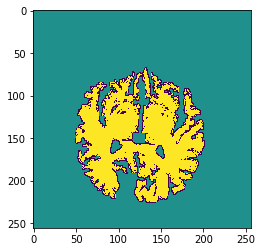

In [140]:
a = region_growing(100,100,69,brain_im) # 69 has been set empirically
plt.imshow(a)


In [68]:
# Sensitivity to the seed

# Sensitivity to the threshold

In [69]:
# Hence the size of the brain is the sum of all the pixels in the grown regions
count = 0
for x in a.ravel():
    if x == 1:
        count = count + 1

print("There are " + str(count) + " pixels in the brain") 

There are 12062 pixels in the brain


## 1.3 Contour detection
Add your implementation and discussion

For the contour detection we will implement the snake algorithm 


In [202]:
#annotations_xmls
def image_show(image, nrows=1, ncols=1, cmap='gray'):
    """
    Function to facilitate ploting of images
    """
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5, 5))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax

def circle_points(resolution, center, radius):
    """
    Generate points which define a circle on an image.
    center := center of the circle in pixels
    radius := radius of the circle in pixels
    """   
    radians = np.linspace(0, 2*np.pi, resolution)
    c = center[1] + radius*np.cos(radians)#polar co-ordinates
    r = center[0] + radius*np.sin(radians)
    
    return np.array([c, r]).T


[[205.00000019 151.99947692]
 [202.55099068 178.38991036]
 [189.70948989 198.36670826]
 [168.21722787 216.64765188]
 [140.57135707 227.49082167]
 [112.22849061 228.34240291]
 [ 90.06097517 223.08638324]
 [ 67.46291113 210.34832474]
 [ 52.84961551 189.02578636]
 [ 44.11837312 161.49857787]
 [ 44.12544344 134.50324973]
 [ 51.90655791 110.97093571]
 [ 67.5290912   89.67063933]
 [ 92.11349815  74.90658721]
 [121.86045101  68.28007158]
 [144.63003825  70.509719  ]
 [169.78393749  82.38389851]
 [187.70952178 100.72952559]
 [200.55701382 125.37450441]]


"\nfig, axes = plt.subplots(2, 2, figsize=(6, 6))\nfig.set_size_inches(18.5, 10.5)\naxes[0][0].imshow(brain_im, cmap='gray')\naxes[0][0].plot(points[:, 0], points[:, 1], '--r', lw=3)\naxes[0][0].set_title('Filtered gaussian')\naxes[0][1].imshow(brain_ddx)\naxes[0][1].set_title('ddx')\naxes[1][0].imshow(brain_ddy)\naxes[1][0].set_title('ddy')\naxes[1][1].imshow(brain_hildreth)\naxes[1][1].set_title('hildreth')\n"

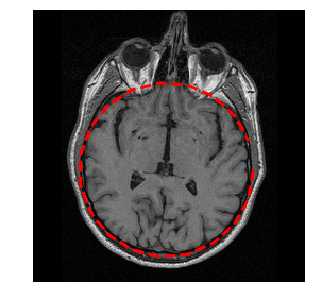

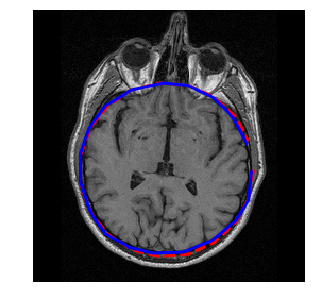

In [204]:

###### TEST RUN ######

# Generate circle points
points = circle_points(20, [150, 125], 82)[:-1]

# Plot circle points
fig, ax = image_show(brain_im)
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)

image_gray = color.rgb2gray(brain_im)

# Create active contour starting at the circle points
snake = seg.active_contour(image_gray, points, beta=0.1,w_line=-6.0, w_edge=10)

# Plot the circle points and the resulting active contour

fig, ax = image_show(brain_im)
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3);
print(snake)

"""
fig, axes = plt.subplots(2, 2, figsize=(6, 6))
fig.set_size_inches(18.5, 10.5)
axes[0][0].imshow(brain_im, cmap='gray')
axes[0][0].plot(points[:, 0], points[:, 1], '--r', lw=3)
axes[0][0].set_title('Filtered gaussian')
axes[0][1].imshow(brain_ddx)
axes[0][1].set_title('ddx')
axes[1][0].imshow(brain_ddy)
axes[1][0].set_title('ddy')
axes[1][1].imshow(brain_hildreth)
axes[1][1].set_title('hildreth')
"""

circumference_snake = sum()

Text(0.5, 1.0, 'hildreth')

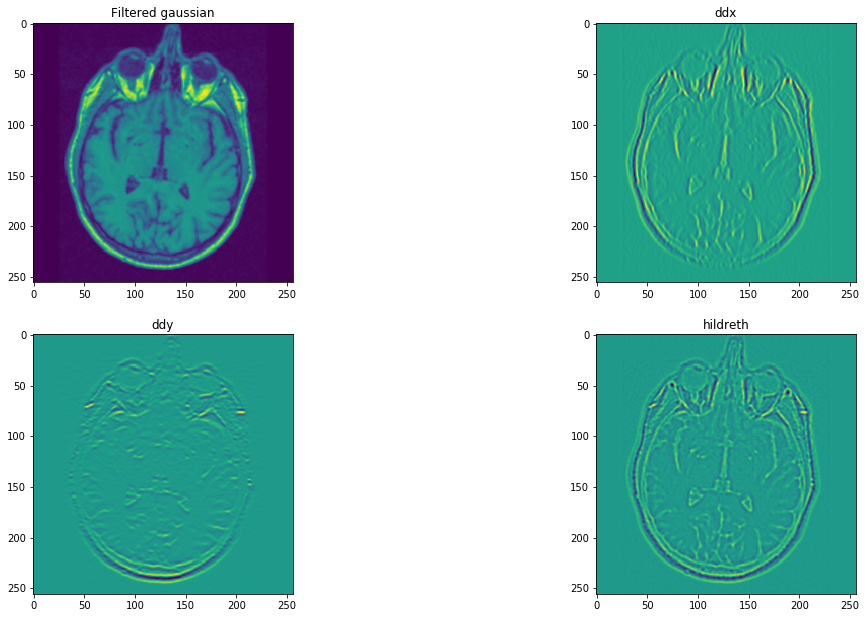

In [70]:
# Marr-Hildreths method 
def gaussian_filter(fSize, fSigma):
    x, y = np.mgrid[-fSize//2 + 1:fSize//2 + 1, -fSize//2 + 1:fSize//2 + 1]
    #print(x)
    g = np.exp(-((x**2 + y**2)/(2.0*fSigma**2)))
    return g/g.sum()


gaus = gaussian_filter(3,2)
filtered_brain = cv2.filter2D(brain_im, -1, gaus)

#Compute gradient in x-direction of picture
brain_dx = cv2.Sobel(np.float32(filtered_brain), cv2.CV_32F,1,0) #Last two numbers = dx, dy 
brain_ddx = cv2.Sobel(np.float32(brain_dx), cv2.CV_32F,1,0) #Last two numbers = dx, dy 
#Compute gradient in y-direction
brain_dy = cv2.Sobel(np.float32(filtered_brain), cv2.CV_32F,0,1) #Last two numbers = dx, dy 
brain_ddy = cv2.Sobel(np.float32(brain_dy), cv2.CV_32F,0,1) #Last two numbers = dx, dy 

brain_hildreth = brain_ddy + brain_ddx

fig, axes = plt.subplots(2, 2, figsize=(6, 6))
fig.set_size_inches(18.5, 10.5)
axes[0][0].imshow(filtered_brain)
axes[0][0].set_title('Filtered gaussian')
axes[0][1].imshow(brain_ddx)
axes[0][1].set_title('ddx')
axes[1][0].imshow(brain_ddy)
axes[1][0].set_title('ddy')
axes[1][1].imshow(brain_hildreth)
axes[1][1].set_title('hildreth')
#gaus_img = skimage.filters.gaussian(brain_im, sigma=3)
#plt.imshow(gaus_img, cmap=plt.cm.gray)


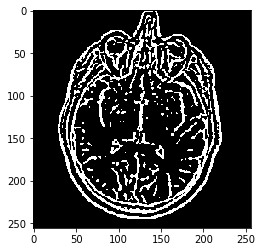

In [71]:
retval, thresholded = cv2.threshold(brain_hildreth, 180, 200, cv2.THRESH_BINARY)
plt.imshow(thresholded, cmap = plt.cm.gray)


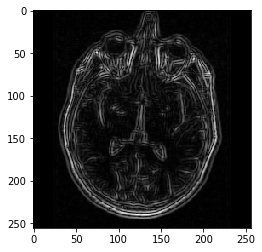

In [72]:
#calculate magnitude 
#ACTIVE CONTOURS 
#FIND CONTOURS - DELETE SOME OF SKULL / EYES - AREA OF CONTOURS(?)
#
grad_mag = np.sqrt(brain_ddx**2 + brain_ddy**2)
plt.imshow(grad_mag, cmap = plt.cm.gray)

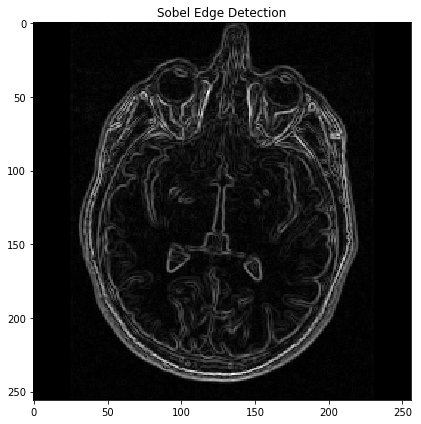

In [73]:
#Sobel filtering 

edge_sobel = skimage.filters.sobel(brain_im)

plt.figure(figsize = (6,6))
plt.imshow(edge_sobel, cmap=plt.cm.gray)
plt.title('Sobel Edge Detection')
plt.tight_layout()
plt.show()

#Apply regiongrowing from the centre, with new contours 

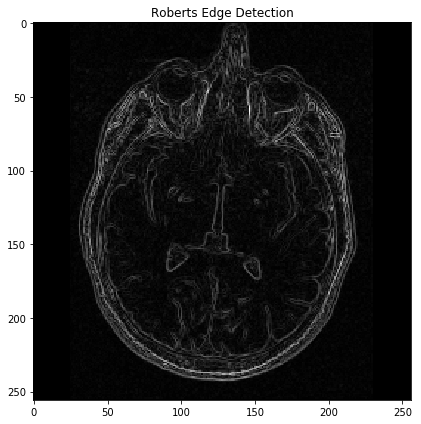

In [74]:
# Roberts filtering 
edge_sobel = skimage.filters.roberts(brain_im)

plt.figure(figsize = (6,6))
plt.imshow(edge_sobel, cmap=plt.cm.gray)
plt.title('Roberts Edge Detection')
plt.tight_layout()
plt.show()

### 1.4 Additional method(s)
Will start with this, as easy methods can be implemented for visualization. 


### 1.5 Thresholding
We assume the brain is the gray-area not connected to the scull edges. In essence, the circular shape. 

In [75]:
def treshold(im, t1,t2):
    im_treshold = im.copy()
    im_treshold[im_treshold<t1] = 0
    im_treshold[im_treshold>t2] = 0
    im_treshold[(im_treshold>=t1) & (im_treshold<=t2)] = 255
    return im_treshold

    

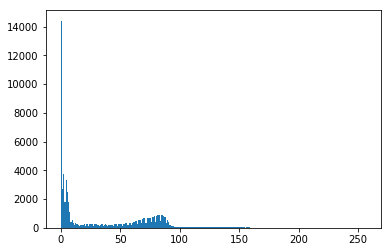

In [76]:
# Histogram thresholding for identifying the brain area 
brain_hist = plt.hist(brain_im.ravel(), 256,[0,256])


Text(0.5, 1.0, 'Filtered brain')

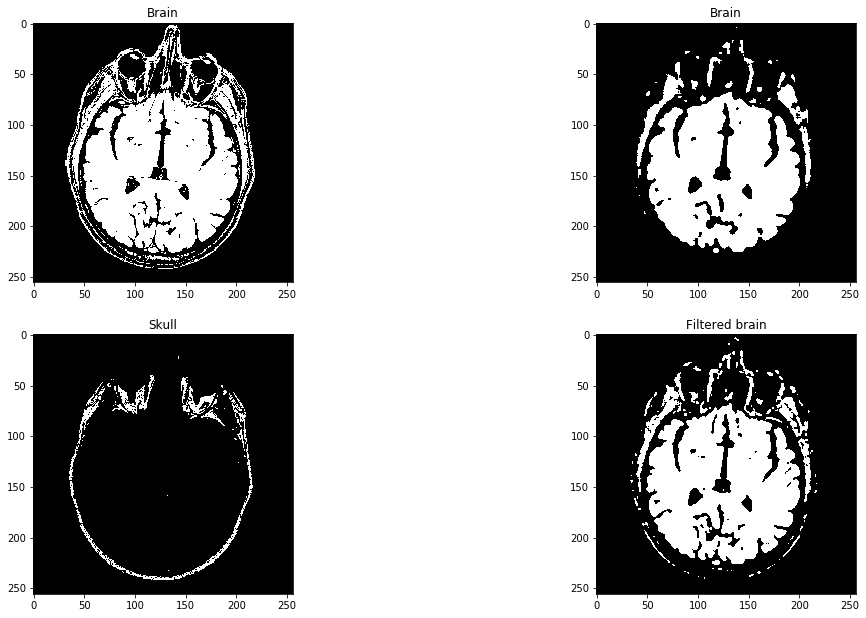

In [179]:
#brain_im_2 = skimage.filters.threshold_itsu(brain_im)

brain_tresholded = treshold(brain_im,50,100)
brain_tresholded_test = treshold(brain_im, 60,100)
skull_tresholded = treshold(brain_im,100,150)
total_tresholded = treshold(brain_im,60,100)

brain_tresholded = cv2.medianBlur(brain_tresholded,1)
total_tresholded = cv2.medianBlur(total_tresholded,3)
skull_tresholded = cv2.medianBlur(skull_tresholded,1)
brain_tresholded_test = cv2.medianBlur(brain_tresholded_test, 5)
fig, axes = plt.subplots(2, 2, figsize=(6, 6))
fig.set_size_inches(18.5, 10.5)
axes[0][0].imshow(brain_tresholded, cmap = 'gray')
axes[0][0].set_title('Brain')
axes[0][1].imshow(brain_tresholded_test, cmap = 'gray')
axes[0][1].set_title('Brain')
axes[1][0].imshow(skull_tresholded, cmap = 'gray')
axes[1][0].set_title('Skull')
axes[1][1].imshow(total_tresholded, cmap = 'gray')
axes[1][1].set_title('Filtered brain')

In [180]:
print(brain_im.shape)
#fig, ax = skimage.filters.try_all_threshold(brain_im, figsize=(10, 8), verbose=False)
#plt.show()

(256, 256)


[[205.         152.15151887]
 [200.66537934 176.43957972]
 [188.13124075 199.13701704]
 [168.75585265 216.97331826]
 [144.63883897 227.55202128]
 [118.39365234 229.72675944]
 [ 92.86392766 223.2618661 ]
 [ 70.75954886 208.85791286]
 [ 53.85485632 188.07597117]
 [ 44.42780366 164.37877256]
 [ 45.01023496 138.82471402]
 [ 54.64207275 113.5851318 ]
 [ 70.81747427  91.14210056]
 [ 92.864366    76.73813387]
 [116.40078123  70.27324055]
 [140.80097801  72.47118966]
 [164.7558527   80.17680917]
 [184.13124075  98.35777786]
 [200.66537934 124.64985028]
 [205.         150.00000004]]


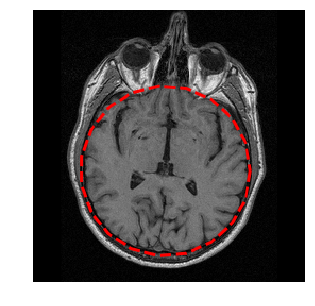

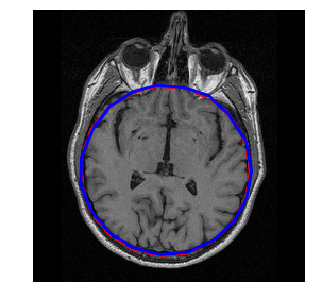

In [193]:
# Generate circle points
# Exclude last point because a closed path should not have duplicate points
points = circle_points(20, [151, 124], 80)

# Plot circle points
fig, ax = image_show(brain_im)
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)

#image_gray = color.rgb2gray(brain_im)
image_gray = brain_tresholded_test
# Create active contour starting at the circle points
snake = seg.active_contour(image_gray, points, beta=0.1,w_line=-4.0, w_edge=12)

# Plot the circle points and the resulting active contour
fig, ax = image_show(brain_im)
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3);
print(snake)

#### 1.5.1 Tresholding brain area estimations

In [47]:

#This is very simple, but also an estimation 
#Sum all pixels of value 1 from the square starting at (55,75),(55,200), (200,75),(200,200)

estimated_brain = brain_tresholded[55:200, 75:200]
high_values = estimated_brain[estimated_brain > 0]
total_pixels_estimated = len(high_values)
print('The total pixels of the brain is estimated to be', total_pixels_estimated)

The total pixels of the brain is estimated to be 13992


In [100]:
#Alternative method = brain area - skull area 
brain_and_skull = total_tresholded[total_tresholded>0]
skull = skull_tresholded[skull_tresholded>0]
brain_area = len(brain_and_skull) - len(skull)
print('The total pixels of the brain is estimated to be', brain_area)

The total pixels of the brain is estimated to be 16178


## Part 2: Save the bees !

Varroa mites are recognized as the biggest pest to honey bees worldwide, and are believed to be the single largest contributing factor in the modern-day decline of honey bees due to their ability to transmit diseases, resulting in death or severe deformity of the pupae. 

Detecting and quantifying the presence of Verroa in a beehive is therefore crucial to treat the infection appropriately and as early as possible, and image analysis appears very useful in this problem.

![Varroa Mite](https://lts5www.epfl.ch/wp-content/uploads/2018/07/varroa-2.jpg)



### 2.1 Introduction to Project

You will find hereafter a set of 4 images taken under real conditions. In this task you will be ask to:
1. Count the number of Varroa on each picture
2. Determine the Intersection over Union of the detected patterns w.r.t. the ground truth
3. Estimate the Precision, Recall and F1-score at two different IoU thresholds $T = {0.5 \text{, and } 0.9}$


**Note** 

Try to have the same routine(s) running on the four images, and giving (approximatively) the same results. The routine(s) that you will write for this part will be useful for the final project as well, so pay special attention to it.

#### Vocabulary


* **IoU**: Let $A$ be the ground truth area and $B$ the predicted one. the intersection over union (IoU) is given as:
$$IoU(A,B) = \frac{A \cap B}{A \cup B} = \frac{\text{Area of Overlap}}{\text{Area of Union}}$$
Let $T$ be a scalar in the interval $[0, 1]$, then $B$ will be considered as a true positive (TP) if and only if $IoU(A,B) \ge T$. As a results, we can evaluate the performance of our detection with different values of $T$. The larger $T$ is, the more constraining is our condition.


* **Precision**: The precision is given as:
$$precision = \frac{tp}{tp + fp}$$
where $tp$ is the number of true positives and $fp$ the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.


* **Recall**: The recall is given as:
$$precision = \frac{tp}{tp + fn}$$
where $tp$ is the number of true positives and $fn$ the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.


* **F1-score**: The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:
$$F1 = \frac{2 \cdot precision \cdot recall}{precision + recall}$$


**FAQ**

Q: What to do if I have multiple ground truth $A_i$ and candidates $B_j$ and want to find the best set $(i,j)$ such that $(i, j) = \arg\max_{i,j} IoU(A_i, B_j)$ ? 

A: Here, we recommend to use a brute force approach. It corresponds to compute $IoU(A, B)$ for every possible pairs (i,j) and keep the pair with the highest $IoU$. Note that a candidate $B_j$ can **only** be matched to **one** ground truth area $A_i$.

Here, we visualize the 4 images for our patern detection

In [130]:
# Load images
im_names = ['varroa-01', 'varroa-02', 'varroa-03', 'varroa-04']
filenames = [os.path.join(data_path, name) + '.jpg' for name in im_names]
ic = skimage.io.imread_collection(filenames)
print('Number of images: ', len(ic))

Number of images:  4


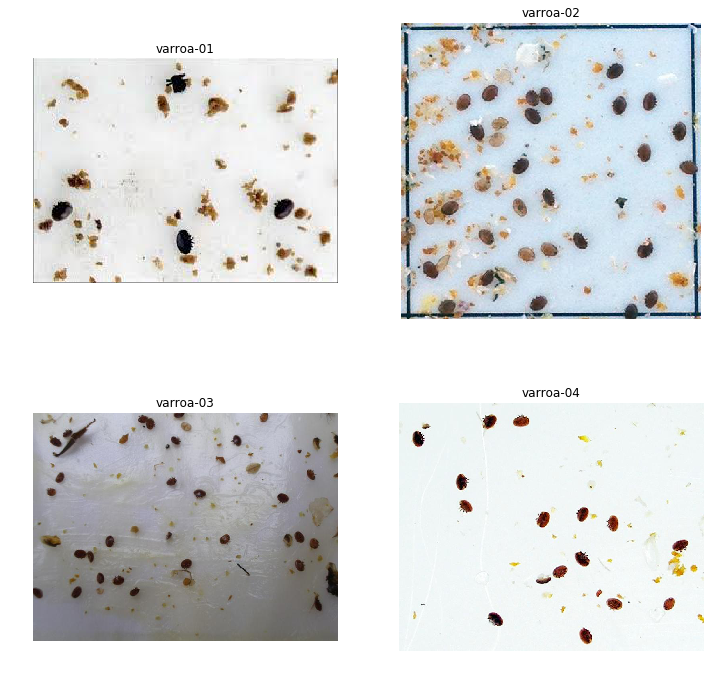

In [131]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), ic, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

We can as well add the groud truth label that are stored in the corresponding XML files. Each xml file stores the position of the varroa on the image as :

```xml
<annotation>
	<object>
		<name>Varroa</name>
		<difficult>0</difficult>
		<bndbox>
			<xmin>14</xmin>
			<ymin>117</ymin>
			<xmax>33</xmax>
			<ymax>137</ymax>
		</bndbox>
	</object>
	<object>
		...
	</object>
	...
</annotation>
```
The block `object` defines the attributes of the varroa. `name` is the definition of the object class (always varroa). `bndbox` is the definition of the bounding box. To simplify your task, we implemented a function named `parse_file` that returns an array with the bounding box of the varroa expressed as `(x, y, width, heigth)` which corresponds to `(xmin, ymin, xmax-xmin, ymax-ymin)`

In [132]:
import xml.etree.ElementTree as ET

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

In [133]:
annotations_xmls = [parse_file(os.path.join(data_path, name) + '.xml') for name in im_names]

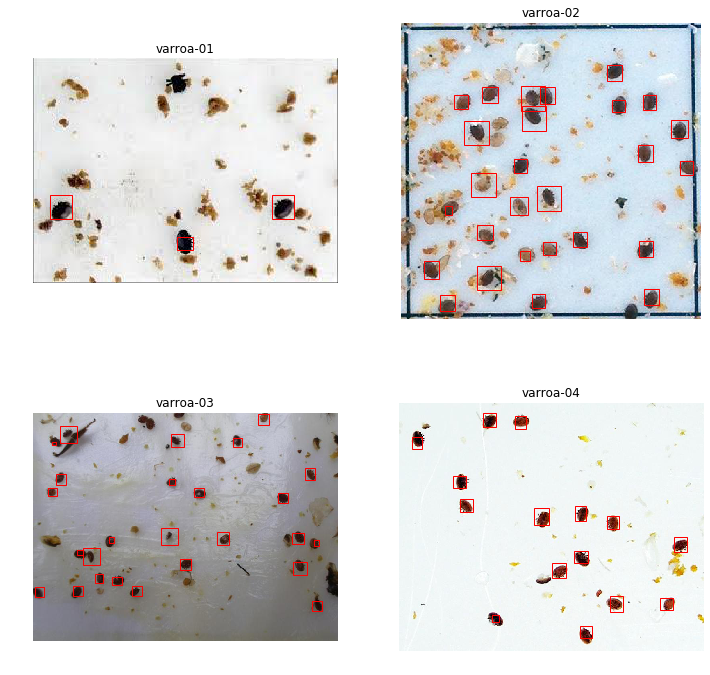

In [138]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm, annotations in zip(axes.ravel(), ic, im_names, annotations_xmls):
    # Iterate over annotations
    for anno in annotations:
        rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Count the number of Varroa on each picture

Add your implementation and discussion

Hint: `skimage.measure.label` might be useful to label the thresholded image

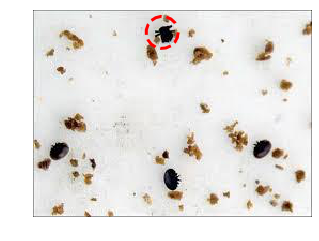

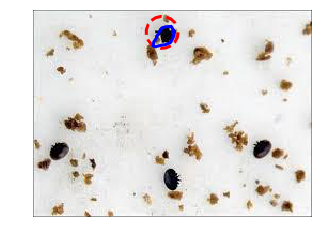

In [134]:
#annotations_xmls
def image_show(image, nrows=1, ncols=1, cmap='gray'):
    """
    Function to facilitate ploting of images
    """
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5, 5))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax

def circle_points(resolution, center, radius):
    """
    Generate points which define a circle on an image.
    center := center of the circle in pixels
    radius := radius of the circle in pixels
    """   
    radians = np.linspace(0, 2*np.pi, resolution)
    c = center[1] + radius*np.cos(radians)#polar co-ordinates
    r = center[0] + radius*np.sin(radians)
    
    return np.array([c, r]).T


###### TEST RUN ######

# Generate circle points
# Exclude last point because a closed path should not have duplicate points
points = circle_points(20, [20, 120], 15)[:-1]

# Plot circle points
fig, ax = image_show(ic[0])
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)

image_gray = color.rgb2gray(ic[0])

# Create active contour starting at the circle points
snake = seg.active_contour(image_gray, points)

# Plot the circle points and the resulting active contour
fig, ax = image_show(ic[0])
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3);

# labels : 29
Rejected ratios 0.22727272727272727
Detected : 4/3


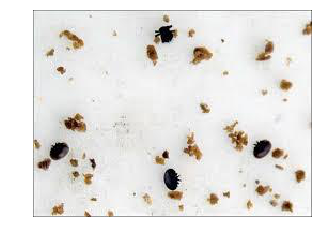

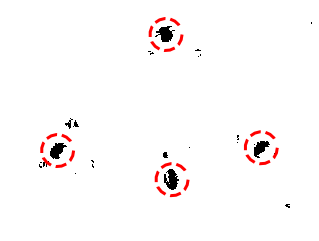

# labels : 169
Rejected eccentricity 0.999885250747518
Rejected eccentricity 0.9986581764139058
Rejected eccentricity 0.9983913548949989
Rejected eccentricity 0.9942897772053403
Rejected eccentricity 0.9968300487892368
Rejected eccentricity 0.9977937586524978
Rejected eccentricity 0.9966213698981413
Rejected eccentricity 0.9842708985907662
Rejected eccentricity 0.9950275187832874
Rejected eccentricity 0.981772859500228
Rejected eccentricity 0.9986294960741938
Rejected ratios 1.7826040668582988
Rejected ratios 0.2851059299478335
Rejected ratios 2.067709996806132
Rejected ratios 2.507824976045992
Detected : 22/27


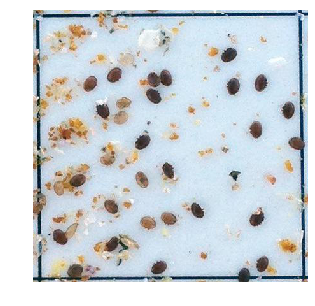

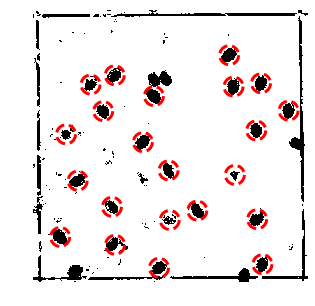

# labels : 74
Rejected eccentricity 0.9890720857865696
Rejected ratios 1.8738563586459287
Rejected ratios 4.069419030192131
Detected : 27/26


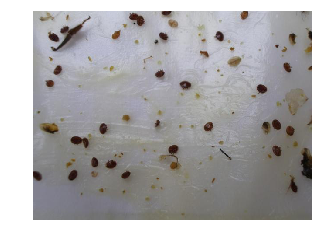

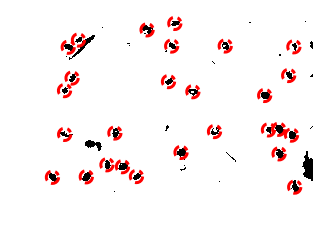

# labels : 49
Rejected eccentricity 0.9541830050262359
Detected : 15/15


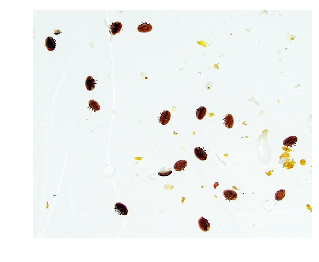

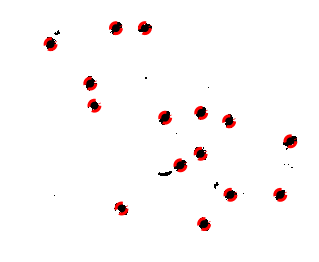

In [135]:
# Count centers -> Threshold and find areas with black relative circles 

def find_creatures(im, 
                   max_eccentricity=0.95, 
                   lower_average_bound=0.3, 
                   higher_average_bound=1.7):
    """
    Take a RGB image,
    threshold it using (minimum algo)
    Label the thresholded images.
    Then disregard the labels whose px count is lower than average
    Then disregard the labels whose eccentricty is lower than max_eccentricity
    Then disregard the labels whose px count isn't within 
    (current_average*lower_average_bound; current_average*higher_average_bound)
    Return the thresholded image and a list of the regions of the found creatures
    """
    
    # Convert RGB to GRAYSCALE
    gray_im = color.rgb2gray(im)

    # Threshold determination
    thresh = skimage.filters.threshold_minimum(gray_im)

    # Thresholding
    binary = gray_im > thresh

    # Label the thresholded image 
    labeled_im = skimage.measure.label(binary, background=True)
    
    # List the different labels that aren't the background
    labels = np.unique(labeled_im[labeled_im!=0])
    print("# labels : " + str(len(labels)) )
    
    good_regions = regionprops(labeled_im)
    
    # Find average area
    areas = []
    for region in good_regions:
        areas.append(region.area)
    avg_area = np.mean(areas) #Can easily change this criteria to rather check for all neighbors > 10 pixels etc.
    
    # Keep the labels with area higher than average amongst the low eccentricity labels
    tmp_good_regions = []
    for region in good_regions:
        if region.area > avg_area:
            tmp_good_regions.append(region)
    good_regions = tmp_good_regions
    
    # Only keep the labels that aren't too elongated
    tmp_good_regions = []
    for region in good_regions:
        if region.eccentricity < max_eccentricity:
            tmp_good_regions.append(region)
        else:
            print("Rejected eccentricity " + str(region.eccentricity))
   
    good_regions = tmp_good_regions
    
    # Find average area of the good regions
    areas = []
    for region in good_regions:
        areas.append(region.area)
    new_avg_area = np.mean(areas)
    
    # Only keep the regions whose area are within some arbitrary bounds
    tmp_good_regions = []
    for region in good_regions:
        if (region.area/new_avg_area > lower_average_bound) and (region.area/new_avg_area < higher_average_bound):
            tmp_good_regions.append(region)
        else:
            print("Rejected ratios " + str(region.area/new_avg_area))
    good_regions = tmp_good_regions
    
    return binary, good_regions

###### TEST RUN ######



for im, annotation in zip(ic, annotations_xmls):
    binary, regions = find_creatures(im)

    count = len(regions)
    print("Detected : " + str(count) + "/" + str(len(annotation)))
    image_show(im)
    fig, ax = image_show(binary)

    # Plotting of the cirlces
    centroids = [r.centroid for r in regions]
    circles = []
    for centroid in centroids:
        circles.append(circle_points(20, centroid, 15)[:-1])

    for circle in circles:
        ax.plot(circle[:, 0], circle[:, 1], '--r', lw=3)
    
    plt.show()


### 2.3 IoU of the detected pattern w.r.t. the ground truth

Add your implementation and discussion

Hint: `skimage.measure.regionprops` implements a large variety of descriptors

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc1ca9f54e0>)

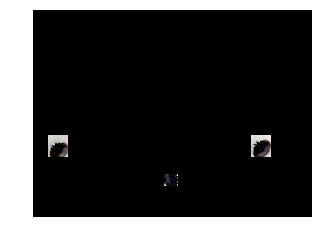

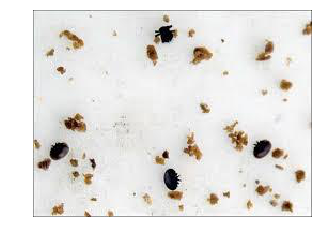

In [149]:
def generate_ground_truth(annotations, img):
    """
    annotations is the list of bug info of an image
    img is the RGB image of those annotations
    ground_truth is an image with 0 where there is no bug, and 1 otherwise
    """
    height = len(img)
    width = len(img[0])
        
    ground_truth = np.zeros([height,width],dtype=np.uint8)
    
    for bug in annotations:        
        bbox = bug['bbox']
        bug_width = bbox[2]
        bug_height = bbox[3]
        
        # generate bounding box corresponding to the bug
        bug = np.zeros([bug_height,bug_width],dtype=np.uint8)
        bug.fill(1)
             
        # insert bug in ground_truth
        bug_top_left_x = bbox[0]
        bug_top_left_y = bbox[1] 
        ground_truth[bug_top_left_y:bug_top_left_y + bug_height, bug_top_left_x:bug_top_left_x + bug_width] = bug
        
    return ground_truth

        
##### TEST RUN #####

img_index = 0

ground_truth = generate_ground_truth(annotations_xmls[img_index], ic[img_index])

(height,width) = ground_truth.shape
img = ic[img_index].copy()
for h in range(0,height):
    for w in range(0,width):
        if ground_truth[h][w] == 0:
            img[h][w] = 0
image_show(img)
image_show(ic[img_index])

In [ ]:
# Are we supposed to check the overlapped between their bounding box and ours ? 

def iou(ground_truth_bbox, our_bbox):
    """
    ground_truth_bbox is a list with [xmin, ymin, width, heigth]
    our_bbox is a list with [xmin, ymin, width, heigth]
    """
    
    ### OVERLAP
    
    # Find intersection box's coordinates
    intersection_xmin = max(our_bbox[0], ground_truth_bbox[0])
    intersection_ymin = max(our_bbox[1], ground_truth_bbox[1])
    intersection_xmax = min(our_bbox[0] + our_bbox[2], 
                            ground_truth_bbox[0] + ground_truth_bbox[2])
    intersection_ymax = min(our_bbox[1] + our_bbox[3], 
                            ground_truth_bbox[1] + ground_truth_bbox[3])

    # Find the intersection box's dimensions
    intersection_box_width = (intersection_xmax - intersection_xmin)
    intersection_box_height = (intersection_ymax - intersection_ymin)
    
    # Check for no overlap
    if (intersection_box_width < 0) or (intersection_box_height < 0):
        return 0
    
    overlap_area = intersection_box_width * intersection_box_height

    ### UNION
    
    our_bbox_area = our_bbox[2] * our_bbox[3]
    ground_truth_bbox_area = ground_truth_bbox_area[2] * ground_truth_bbox_area[3]
    union_area = our_bbox_area + ground_truth_bbox_area - overlap_area

    # Compute IOU
    iou = overlap_area / (area_combined+epsilon)
    return iou

def overlap(ground_truth_bbox, our_bbox):
    """
    Compute the overlap between the two bounding boxes
    """
    # TODO
    
def union(ground_truth_bbox, our_bbox):
    """
    Compute the union between the two bounding boxes
    """
    # TODO

In [25]:
#Print all detected creatures in picture 

#Find automatic way to SET RESOLUTION AND SIZE AUTOMATICALLY!

points = circle_points(20, creature_centers[3], 15)[:-1]

fig, ax = image_show(ic[0])
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)
image_gray = color.rgb2gray(ic[0])

NameError: name 'creature_centers' is not defined

In [138]:
snakes = []
for c_centres in creature_centers: 
    points = circle_points(20, c_centres, 15)[:-1]
    snake = seg.active_contour(image_gray, points)
    snakes.append(snake)

snake_sizes = [len(snake) for snake in snakes]
total_area = sum(snake_sizes)
print('The total expected area of detected varros is', total_area )

NameError: name 'creature_centers' is not defined

### 2.4 Precision, Recall and F1-score at two different IoU thresholds

Add your implementation and discussion

In [40]:
"""
TODO: 
    -Generalize the threshold filtering in count_and_find_centers, it's hardcoded in a way but idk 
    -find a way to automatically set the resolution and radius in circle-points, but it might not be 
    necessary if the snake is good 
    -try one round of total area from all pictures after findin good threshold method / thresholding
    all pictures good  -> See how shitty / good it is 
    -do the last task to calculate stuff 
    
"""

"\nTODO: \n    -Generalize the threshold filtering in count_and_find_centers, it's hardcoded in a way but idk \n    -find a way to automatically set the resolution and radius in circle-points, but it might not be \n    necessary if the snake is good \n    -try one round of total area from all pictures after findin good threshold method / thresholding\n    all pictures good  -> See how shitty / good it is \n    -do the last task to calculate stuff \n    \n"